# Preprocessing:
    Train set/Test set creation
    Elimination of Na
    Encoding
    Elimination of outliers
    Features Selection
    Feature Engineering
    Feature Scaling 


### Importing Libraries 

In [1]:

import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFECV

#cross validation 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

#scorring 
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#Common Model Algorithms
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier




### Data preparation after exploration

In [2]:
#Reading Data 
dfb=pd.read_excel('dataset.xlsx')
df=dfb.copy()

#Elimination of variables with more than 90% of missing data
df=df[df.columns[df.isna().sum()/df.shape[0]<0.9]]

#Elimination of features rapid test (judged less reliable during data exploration)
df=df.drop(['Influenza A, rapid test','Influenza B, rapid test'], axis =1)


#Elimination of feature patient ID
df=df.drop(['Patient ID'], axis =1)

#Elimination of categorical features with only one category (one feature => Parainfluenza 2 )
for col in df.select_dtypes('object').columns:
    df1=df[col].dropna()
#    print(f'{col:-<50} {df1.unique()}')
#    print(len(df1.unique()))
    if len(df1.unique())<2:
        print(f'Dropped feature : {col}')
        df=df.drop([col],axis=1)

#Elimination of all missing data for non catogorical features (blood data)
df=df.dropna(subset=df.select_dtypes('float').columns) #dropping rows will consider only the subset float feature with NA 
print('Data shape {}'.format(df.shape))


Dropped feature : Parainfluenza 2
Data shape (598, 35)


(598, 33)

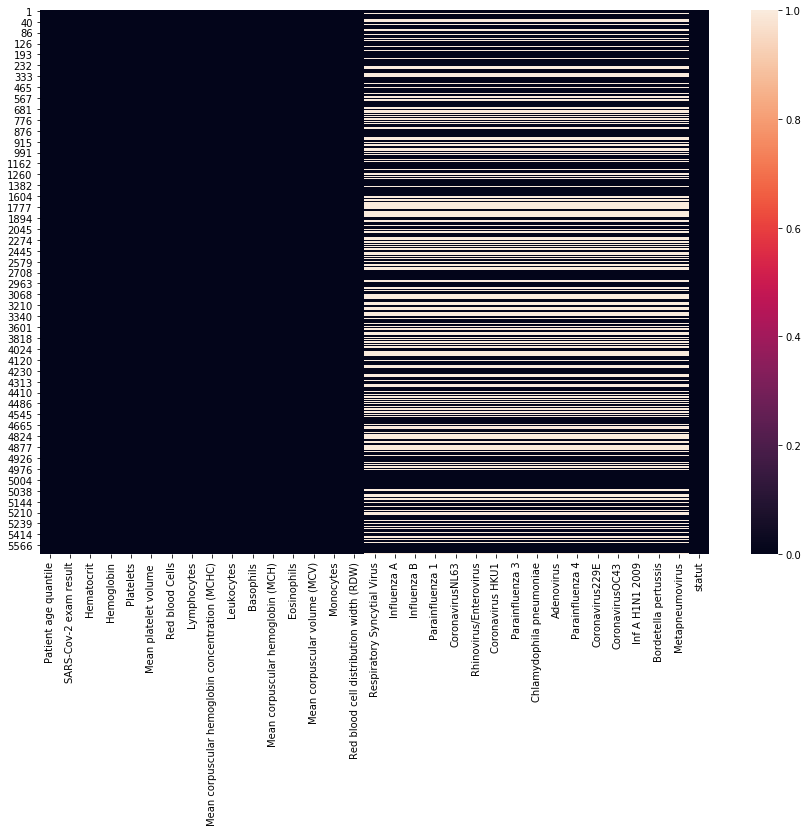

In [3]:
#creation of the "statut" column instead of 3 care columns
def hospitalisation(df) :
    if df['Patient addmited to semi-intensive unit (1=yes, 0=no)']==1:
        return'semi_intensive'   
    if df['Patient addmited to intensive care unit (1=yes, 0=no)']==1:
        return'intensive'
    if df['Patient addmited to regular ward (1=yes, 0=no)']==1:
        return'regular_ward'
    else :
        return 'not_admitted'
df['statut']=df.apply(hospitalisation, axis=1)
df=df.drop(['Patient addmited to regular ward (1=yes, 0=no)','Patient addmited to semi-intensive unit (1=yes, 0=no)','Patient addmited to intensive care unit (1=yes, 0=no)'],axis=1)

plt.figure(figsize=(15,10))
sns.heatmap(df.isna())
df.shape

### Spliting Data 

In [4]:
#Création du Train set/Test set 
#selection des variables et de la target
y=df['SARS-Cov-2 exam result']
X=df.drop(['SARS-Cov-2 exam result'], axis=1)
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.2, random_state=0)
X_train.shape

(478, 32)

# Modelling

In [5]:
numerical_Features = make_column_selector(dtype_include=np.number)
categorical_Features = make_column_selector(dtype_exclude=np.number)

numerical_pipeline = make_pipeline(SimpleImputer(),StandardScaler())
categorical_pipeline= make_pipeline(SimpleImputer(strategy='most_frequent'),OneHotEncoder(handle_unknown='ignore'))

transformer=make_column_transformer((numerical_pipeline, numerical_Features), (categorical_pipeline,categorical_Features))
Xtransformed=transformer.fit_transform(X_train)
Xtesttransformed=transformer.transform(X_test)

#Transformation of the target 
encoderY =LabelEncoder()
#ytransformed=transformer.fit_transform(y_train)
y_transformed=encoderY.fit_transform(y_train)
ytesttransformed=encoderY.transform(y_test)


random_state=0
classifiers = [
              LogisticRegression(random_state = random_state),
              LinearDiscriminantAnalysis(),
              KNeighborsClassifier(),
              SVC(random_state=random_state),
              DecisionTreeClassifier(random_state=random_state),
              RandomForestClassifier(random_state=random_state),
              AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1),
              GradientBoostingClassifier(random_state=random_state),
              MLPClassifier(max_iter=2000,random_state=random_state),
              SGDClassifier(random_state = random_state)
              ]
res_columns=['clf name', 'clf accuracy Mean', 'clf recall','clf precision','clf f1score','clfrecalltest']
df_result = pd.DataFrame(columns = res_columns)

cv=StratifiedKFold(5)
idx_raws=0
for cl in classifiers: 
    
    cl.fit(Xtransformed,y_transformed)
    df_result.loc[idx_raws, 'clf name']= cl.__class__.__name__
    df_result.loc[idx_raws,'clf accuracy Mean' ]=cross_val_score(cl,Xtransformed, y_transformed, scoring='accuracy', cv=cv).mean()
    df_result.loc[idx_raws,'clf recall' ]=cross_val_score(cl,Xtransformed, y_transformed, scoring='recall', cv=cv).mean()
    df_result.loc[idx_raws,'clf precision' ]=cross_val_score(cl,Xtransformed, y_transformed, scoring='precision', cv=cv).mean()
    df_result.loc[idx_raws,'clf f1score' ]=cross_val_score(cl,Xtransformed, y_transformed, scoring='f1', cv=cv).mean()
    df_result.loc[idx_raws,'clfrecalltest' ]=recall_score(ytesttransformed,cl.predict(Xtesttransformed))
    
    idx_raws=idx_raws+1

df_result.sort_values(by='clfrecalltest',ascending=False,inplace=True)
df_result

,clf name,clf accuracy Mean,clf recall,clf precision,clf f1score,clfrecalltest
0,LogisticRegression,0.910088,0.545055,0.804383,0.634286,0.615385
1,LinearDiscriminantAnalysis,0.893333,0.528571,0.715556,0.585934,0.538462
4,DecisionTreeClassifier,0.838947,0.514286,0.457692,0.475188,0.538462
9,SGDClassifier,0.884912,0.327473,0.84,0.426274,0.538462
6,AdaBoostClassifier,0.841053,0.52967,0.480558,0.495328,0.461538
7,GradientBoostingClassifier,0.895482,0.514286,0.704155,0.579235,0.461538
2,KNeighborsClassifier,0.882917,0.471429,0.625672,0.535672,0.384615
3,SVC,0.91,0.40989,0.904762,0.560325,0.307692
5,RandomForestClassifier,0.899627,0.368132,0.846984,0.504278,0.307692
8,MLPClassifier,0.91636,0.618681,0.780375,0.681416,0.307692


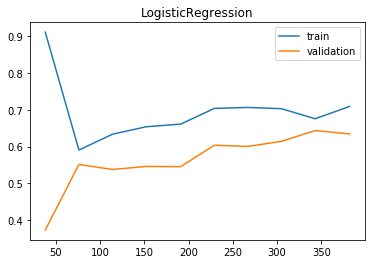

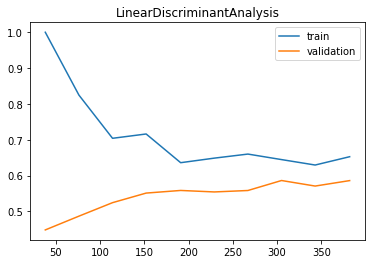

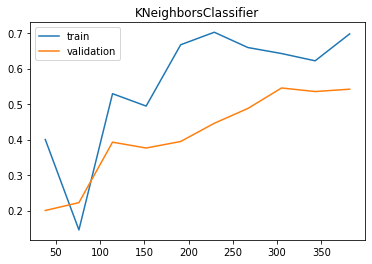

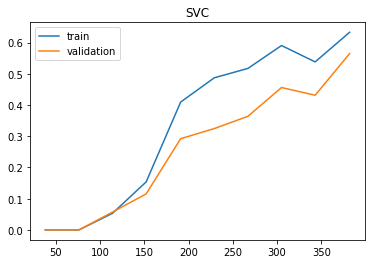

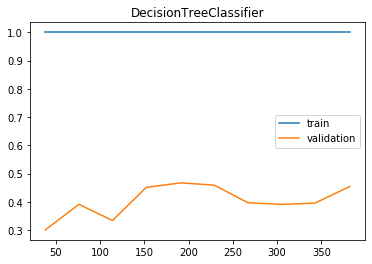

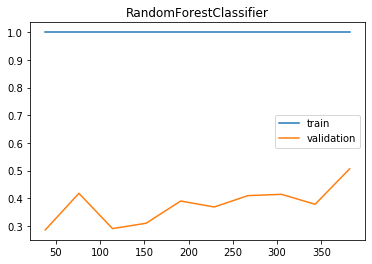

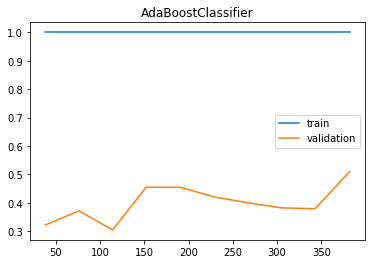

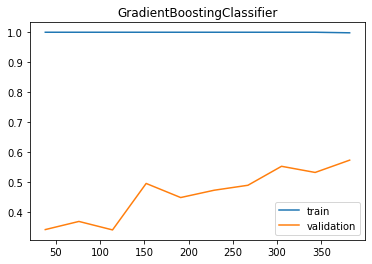

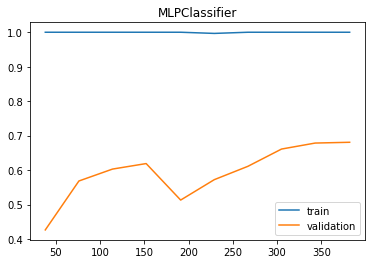

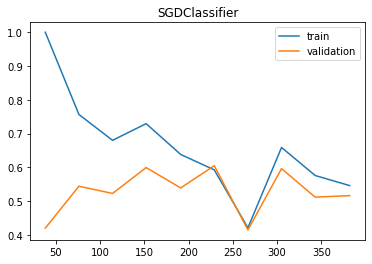

In [6]:
#Learning curve 
from sklearn.model_selection import learning_curve 
for cl in classifiers:
    N,train_score, val_score=learning_curve(cl, Xtransformed, y_transformed,train_sizes=np.linspace(0.1,1,10),scoring='f1',cv=cv)
    plt.figure()
    plt.plot(N,train_score.mean(axis=1),label='train')
    plt.plot(N,val_score.mean(axis=1),label='validation')
    plt.legend()
    plt.title(cl.__class__.__name__)

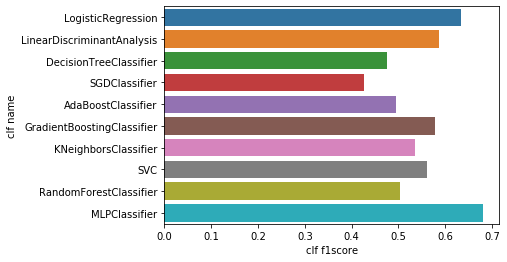

In [7]:
plt.figure()
sns.barplot(x=df_result['clf f1score'],y=df_result['clf name'],data=df_result)

### GridSearch for Logitic Regression model

In [8]:
param_grid={'penalty': ['l1','l2'],'C':[20,40,45,50,55,70]}
GridLR=GridSearchCV(LogisticRegression(solver='liblinear',max_iter=1000), param_grid,cv=cv,scoring='recall')
GridLR.fit(Xtransformed, y_transformed)
LRBest=GridLR.best_estimator_
print ('Param of the best model LR {}'.format(GridLR.best_params_))
print ('CV recall_score model with the best param : {:.2f}'.format(GridLR.best_score_))
print('recall score calculated on test data : {:2f}'.format(recall_score(ytesttransformed,LRBest.predict(Xtesttransformed))))

Param of the best model LR {'C': 20, 'penalty': 'l1'}
CV recall_score model with the best param : 0.60
recall score calculated on test data : 0.615385


In [9]:
#GridSearch Logitic Regression avec feature engenieering
modelLR=make_pipeline(transformer,PolynomialFeatures(),LRBest)
param_grid={'polynomialfeatures__degree': [2,3]}

GridLR2=GridSearchCV(modelLR, param_grid,cv=cv,scoring='recall')
GridLR2.fit(X_train, y_transformed)
LRBest2=GridLR2.best_estimator_

print ('Param for the best model LR {}'.format(GridLR2.best_params_))
print ('CV recall_score model with the best param : {:.2f}'.format(GridLR2.best_score_))
print('recall score calculated on test data : {:2f}'.format(recall_score(ytesttransformed,LRBest2.predict(X_test))))

Param for the best model LR {'polynomialfeatures__degree': 3}
CV recall_score model with the best param : 0.63
recall score calculated on test data : 0.384615


Text(0.5, 1.0, 'LogisticRegression')

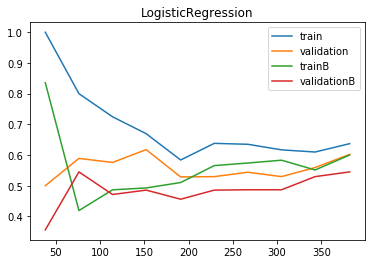

In [10]:
#Learning curve basic LR model with the best one  
N,train_score, val_score=learning_curve(LRBest, Xtransformed, y_transformed,train_sizes=np.linspace(0.1,1,10),scoring='recall',cv=cv)
Nb,train_scoreb, val_scoreb=learning_curve(LogisticRegression(), Xtransformed, y_transformed,train_sizes=np.linspace(0.1,1,10),scoring='recall',cv=cv)
plt.figure()
plt.plot(N,train_score.mean(axis=1),label='train')
plt.plot(N,val_score.mean(axis=1),label='validation')
plt.plot(Nb,train_scoreb.mean(axis=1),label='trainB')
plt.plot(Nb,val_scoreb.mean(axis=1),label='validationB')
plt.legend()
plt.title(LRBest.__class__.__name__)

### GridSearch for MLP model

In [39]:
#GridSearch MLP
param_grid={'hidden_layer_sizes': [2,500],
            'learning_rate_init': [0.001,0.01],
            'activation':['logistic','tanh'],
            'learning_rate':['constant','adaptive'], 
           }
GridMLP=GridSearchCV(MLPClassifier(max_iter=2000,random_state=random_state), param_grid,cv=cv,scoring='recall')
GridMLP.fit(Xtransformed, y_transformed)
MLPBest=GridMLP.best_estimator_
print ('Param of the best model MLP {}'.format(GridMLP.best_params_))
print ('CV recall_score model with the best param : {:.2f}'.format(GridMLP.best_score_))
print('recall score calculated on test data : {:2f}'.format(recall_score(ytesttransformed,MLPBest.predict(Xtesttransformed))))

Param of the best model MLP {'activation': 'tanh', 'hidden_layer_sizes': 2, 'learning_rate': 'constant', 'learning_rate_init': 0.01}
CV recall_score model with the best param : 0.71
recall score calculated on test data : 0.769231


In [12]:
#GridSearch MLP with feature selection 'SelectFromModel'
selector=SelectFromModel(SGDClassifier(random_state=1))
modelMLP=make_pipeline(transformer, selector, MLPBest)
param_grid={ 'selectfrommodel__threshold':[0,'0.5*mean','mean','1.5*mean']}

GridMLP2=GridSearchCV(modelMLP, param_grid,cv=cv,scoring='f1')
GridMLP2.fit(X_train, y_transformed)
MLPBest2=GridMLP2.best_estimator_

print ('Param for the best model MLP {}'.format(GridMLP2.best_params_))
print ('CV recall_score model with the best param : {:.2f}'.format(GridMLP2.best_score_))
print('recall score calculated on test data : {:2f}'.format(recall_score(ytesttransformed,MLPBest2.predict(X_test))))

Param for the best model MLP {'selectfrommodel__threshold': 0}
CV recall_score model with the best param : 0.69
recall score calculated on test data : 0.769231


In [13]:
#GridSearch MLP with feature selection 'RFECV'
#selector2=RFECV(SGDClassifier(),step=1 ,min_features_to_select=2,cv=5)

selector3=RFECV(SGDClassifier(random_state=1),step=1,cv=5)
modelMLP=make_pipeline(transformer, selector3, MLPBest)

param_grid={ 'rfecv__min_features_to_select':[5,10,20,28,48]}
GridMLP3=GridSearchCV(modelMLP, param_grid,cv=cv,scoring='f1')
GridMLP3.fit(X_train, y_transformed)
MLPBest3=GridMLP3.best_estimator_

print ('Param for the best model MLP {}'.format(GridMLP3.best_params_))
print ('CV recall_score model with the best param : {:.2f}'.format(GridMLP2.best_score_))
print('recall score calculated on test data : {:2f}'.format(recall_score(ytesttransformed,MLPBest3.predict(X_test))))

Param for the best model MLP {'rfecv__min_features_to_select': 48}
CV recall_score model with the best param : 0.69
recall score calculated on test data : 0.769231


Text(0.5, 1.0, 'MLPClassifier')

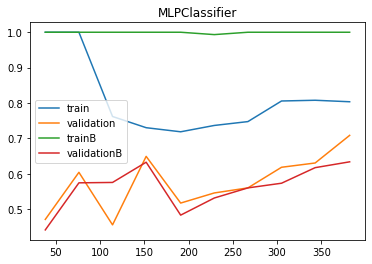

In [14]:
#Learning Curve MLP
N,train_score, val_score=learning_curve(MLPBest, Xtransformed, y_transformed,train_sizes=np.linspace(0.1,1,10),scoring='recall',cv=cv)
Nb,train_scoreb, val_scoreb=learning_curve(MLPClassifier(max_iter=2000,random_state=random_state), Xtransformed, y_transformed,train_sizes=np.linspace(0.1,1,10),scoring='recall',cv=cv)

plt.figure()
plt.plot(N,train_score.mean(axis=1),label='train')
plt.plot(N,val_score.mean(axis=1),label='validation')
plt.plot(Nb,train_scoreb.mean(axis=1),label='trainB')
plt.plot(Nb,val_scoreb.mean(axis=1),label='validationB')
plt.legend()
plt.title(MLPBest.__class__.__name__)

### GridSearchCV for Gradient Boosting Classifier

In [15]:
params={'n_estimators':[20,50,100,300],
        #'subsample':np.linspace(0,1,2),
        'learning_rate':[0.1,0.3,0.9],
        'loss':['exponential','deviance'],
        'criterion':['friedman_mse','mse','mae'],
        #'max_features':['auto', 'sqrt', 'rbf', 'log2'],
        'max_features':['auto', 'sqrt', 'log2']
       }
        
GridGB=GridSearchCV(GradientBoostingClassifier(random_state=random_state), param_grid=params,cv=cv,scoring='recall')
GridGB.fit(Xtransformed, y_transformed)
GBBest=GridGB.best_estimator_

print ('Param for the best model GB {}'.format(GridGB.best_params_))
print ('CV recall_score model with the best param : {:.2f}'.format(GridGB.best_score_))
print('recall score calculated on test data : {:2f}'.format(recall_score(ytesttransformed,GBBest.predict(Xtesttransformed))))

Param for the best model GB {'criterion': 'mae', 'learning_rate': 0.9, 'loss': 'deviance', 'max_features': 'sqrt', 'n_estimators': 300}
CV recall_score model with the best param : 0.62
recall score calculated on test data : 0.538462


Text(0.5, 1.0, 'GradientBoostingClassifier')

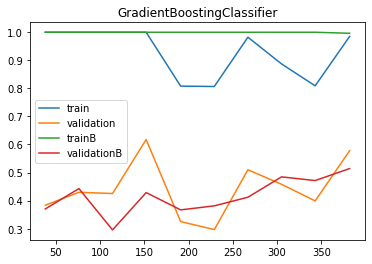

In [16]:
#Learning Curve for Gradient Boosting Classifier
N,train_score, val_score=learning_curve(GBBest, Xtransformed, y_transformed,train_sizes=np.linspace(0.1,1,10),scoring='recall',cv=cv)
Nb,train_scoreb, val_scoreb=learning_curve(GradientBoostingClassifier(random_state=random_state), Xtransformed, y_transformed,train_sizes=np.linspace(0.1,1,10),scoring='recall',cv=cv)

plt.figure()
plt.plot(N,train_score.mean(axis=1),label='train')
plt.plot(N,val_score.mean(axis=1),label='validation')
plt.plot(Nb,train_scoreb.mean(axis=1),label='trainB')
plt.plot(Nb,val_scoreb.mean(axis=1),label='validationB')
plt.legend()
plt.title(GBBest.__class__.__name__)

In [52]:
best = [LRBest,MLPBest,GBBest]             
for cl in best :
    print(f'Classification_report on test data for the  best model {cl.__class__.__name__} est ')
    print(classification_report(ytesttransformed,cl.predict(Xtesttransformed)))


Classification_report on test data for the  best model LogisticRegression est 
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       107
           1       0.62      0.62      0.62        13

    accuracy                           0.92       120
   macro avg       0.78      0.78      0.78       120
weighted avg       0.92      0.92      0.92       120

Classification_report on test data for the  best model MLPClassifier est 
              precision    recall  f1-score   support

           0       0.97      0.86      0.91       107
           1       0.40      0.77      0.53        13

    accuracy                           0.85       120
   macro avg       0.68      0.81      0.72       120
weighted avg       0.91      0.85      0.87       120

Classification_report on test data for the  best model GradientBoostingClassifier est 
              precision    recall  f1-score   support

           0       0.94      0.93      0.94       1

<Figure size 576x576 with 0 Axes>

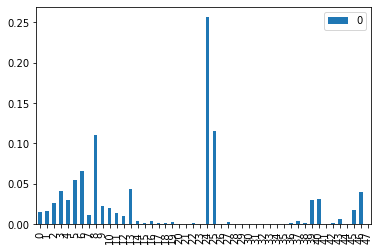

In [17]:
# Visualization of GBBest feature_importances
plt.figure(figsize=(8,8))
pd.DataFrame(GBBest.feature_importances_,index=np.arange(Xtransformed.shape[1])).plot.bar()
#Xtransformed.shape

### Ensemble learning Voting & Bagging

In [43]:
#Ensemble learning (Voting/ boosting/bagging)
from sklearn.ensemble import VotingClassifier, BaggingClassifier
VotingC=VotingClassifier([('MLP',MLPBest),('LR',LRBest)],voting='soft')
cross_val_score(VotingC,Xtransformed, y_transformed, scoring='recall', cv=cv).mean()


0.6175824175824176

In [ ]:
#bagging
classifiers1 = [
              #LogisticRegression(max_iter=1000,random_state = random_state),
              LRBest,
              #LinearDiscriminantAnalysis(),
              #KNeighborsClassifier(),
              #SVC(random_state=random_state),
              #DecisionTreeClassifier(random_state=random_state),
              #RandomForestClassifier(random_state=random_state),
              #AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1),
              #GradientBoostingClassifier(random_state=random_state),
              GBBest,
              #MLPClassifier(max_iter=2000,random_state=random_state),
              MLPBest,
              #SGDClassifier(random_state = random_state)
              

              ]
for cl in classifiers1:
    cl=cl.fit(Xtransformed, y_transformed)
    BC=BaggingClassifier(base_estimator=cl,n_estimators=50)
    BC=BC.fit(Xtransformed, y_transformed)
    score=cross_val_score(BC,Xtransformed, y_transformed, scoring='recall', cv=cv).mean().round(2)
    print(f'Recall score with bagging on the model {cl.__class__.__name__}')
    print(f'\t=> CV recall of the  best model : {score}')
    print(f'\t=> Recall on test data :{recall_score(ytesttransformed,BC.predict(Xtesttransformed)).round(2)}')

Recall score with bagging on the model LogisticRegression
	=> CV recall of the  best model : 0.6
	=> Recall on test data :0.62


### Best Result 

In [53]:
#As there is no overfiting with this model => results can be improved with adding more data. 
print(f'The best model with higher recall on test data is : \n{MLPBest}')
print(f'The score (recall) of this MLP model on test data is : {recall_score(ytesttransformed,MLPBest.predict(Xtesttransformed)).round(2)}')

The best model with higher recall on test data is : 
MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=2, learning_rate='constant',
              learning_rate_init=0.01, max_fun=15000, max_iter=2000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=0, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
The score (recall) of this MLP model on test data is : 0.77
